In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
import librosa
import librosa.filters
import numpy as np

from scipy import signal
from scipy.signal import butter, lfilter
from scipy.io import wavfile
import IPython.display

from swissknife.streamtools import spectral as sp

/home/earneodo/anaconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# This code credit to https://github.com/keithito/tacotron/blob/8edcd55b3f08f0492340e8b3ee60a693138f5473/util/audio.py

def spectrogram(y, hparams):
  D = _stft(preemphasis(y,hparams), hparams)
  S = _amp_to_db(np.abs(D)) - hparams['ref_level_db']
  return _normalize(S, hparams)

def inv_spectrogram(spectrogram, hparams):
  '''Converts spectrogram to waveform using librosa'''
  S = _db_to_amp(_denormalize(spectrogram, hparams) + hparams['ref_level_db'])  # Convert back to linear
  return inv_preemphasis(_griffin_lim(S ** hparams['power'], hparams), hparams)          # Reconstruct phase

def preemphasis(x,hparams):
  return signal.lfilter([1, -hparams['preemphasis']], [1], x)

def inv_preemphasis(x, hparams):
  return signal.lfilter([1], [1, -hparams['preemphasis']], x)

def melspectrogram(y,hparams,_mel_basis):
  D = _stft(preemphasis(y, hparams), hparams)
  S = _amp_to_db(_linear_to_mel(np.abs(D),_mel_basis)) - hparams['ref_level_db']
  return _normalize(S, hparams)

def find_endpoint(wav, hparams, threshold_db=-40, min_silence_sec=0.8):
  window_length = int(hparams['sample_rate'] * min_silence_sec)
  hop_length = int(window_length / 4)
  threshold = _db_to_amp(threshold_db)
  for x in range(hop_length, len(wav) - window_length, hop_length):
    if np.max(wav[x:x+window_length]) < threshold:
      return x + hop_length
  return len(wav)

def _griffin_lim(S, hparams):
  '''librosa implementation of Griffin-Lim
  Based on https://github.com/librosa/librosa/issues/434
  '''
  angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
  S_complex = np.abs(S).astype(np.complex)
  y = _istft(S_complex * angles,hparams)
  for i in range(hparams['griffin_lim_iters']):
    angles = np.exp(1j * np.angle(_stft(y, hparams)))
    y = _istft(S_complex * angles, hparams)
  return y

def _stft(y, hparams):
  n_fft, hop_length, win_length = _stft_parameters(hparams)
  return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

def _istft(y, hparams):
  _, hop_length, win_length = _stft_parameters(hparams)
  return librosa.istft(y, hop_length=hop_length, win_length=win_length)

def _stft_parameters(hparams):
  n_fft = (hparams['num_freq'] - 1) * 2
  hop_length = int(hparams['frame_shift_ms'] / 1000 * hparams['sample_rate'])
  win_length = int(hparams['frame_length_ms'] / 1000 * hparams['sample_rate'])
  return n_fft, hop_length, win_length

def _linear_to_mel(spectrogram, _mel_basis):
  return np.dot(_mel_basis, spectrogram)

def _build_mel_basis(hparams):
  n_fft = (hparams['num_freq'] - 1) * 2
  return librosa.filters.mel(hparams['sample_rate'], n_fft, n_mels=hparams['num_mels'], fmin = hparams['fmin'], fmax=hparams['fmax'])

def _amp_to_db(x):
  return 20 * np.log10(np.maximum(1e-5, x))

def _db_to_amp(x):
  return np.power(10.0, x * 0.05)

def _normalize(S, hparams):
  return np.clip((S - hparams['min_level_db']) / -hparams['min_level_db'], 0, 1)

def _denormalize(S, hparams):
  return (np.clip(S, 0, 1) * -hparams['min_level_db']) + hparams['min_level_db']



In [4]:
wav_file_path = '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/motiff_1.wav'
rate, data = wavfile.read(wav_file_path)
rate

30000

In [5]:
num_seconds = 0.5
data = data[:rate*num_seconds,0]

IndexError: too many indices for array

In [6]:
np.shape(data)

(16768,)

In [7]:
# original wav
IPython.display.Audio(data=data, rate=rate)

In [63]:
hparams = {
    'species':'ST',
    # filtering
    'highcut':3000,
    'lowcut':10,
    
    # spectrograms
    'mel_filter': False, # should a mel filter be used?
    'num_mels':1024, # how many channels to use in the mel-spectrogram
    'num_freq':2048, # how many channels to use in a spectrogram 
    'sample_rate':rate, # what rate are your WAVs sampled at?
    'preemphasis':0.97, 
    'frame_shift_ms':1, # step size for fft
    'frame_length_ms':10, # frame length for fft
    'min_level_db':-50, # minimum threshold db for computing spe 
    'ref_level_db':120, # reference db for computing spec
    'sample_rate':rate, # sample rate of your data
    'fmin': 10, # low frequency cutoff for mel filter
    'fmax': 15000, # high frequency cutoff for mel filter
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':20,
    'power':1.5,
    
}


(2048, 559)


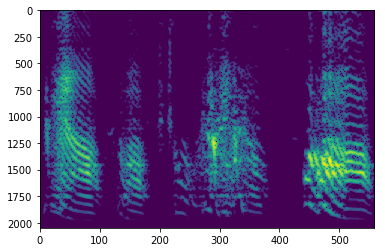

In [64]:
spec = spectrogram(data, hparams)
print(spec.shape)
plt.imshow(spec[::-1], aspect='auto')

In [46]:
data.size/28

598.8571428571429

In [47]:

step_size

30

(2048, 423)


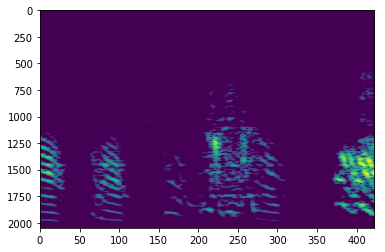

In [48]:
step_size=int(rate*0.001*hparams['frame_shift_ms'])
my_spec = sp.pretty_spectrogram(data, rate, 
                                fft_size=hparams['num_freq']*2, 
                                f_max=hparams['fmax'],
                                step_size = step_size,
                                window=('gaussian', 80))[2]
print(my_spec.shape)

plt.imshow(my_spec[::-1], aspect='auto')
recovered = inv_spectrogram(my_spec, hparams)

(2048, 559)


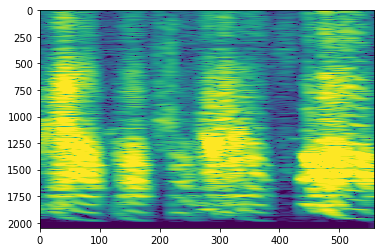

In [59]:
recovered = inv_spectrogram(spec, hparams)

In [60]:
# original wav
IPython.display.Audio(data=recovered, rate=rate)

In [132]:
mel_spec = melspectrogram(data, hparams, _mel_basis)

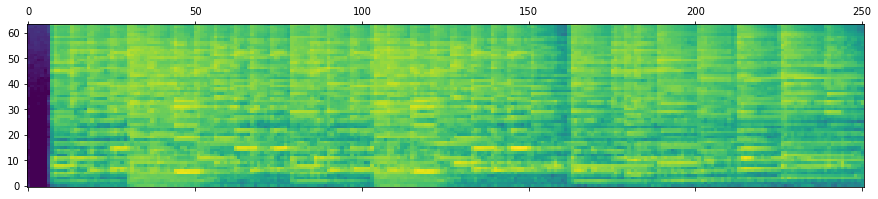

In [133]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,3))
ax.matshow(mel_spec, origin='lower', aspect='auto')
plt.show()

In [134]:
_mel_basis = _build_mel_basis(hparams) # build a basis function if you are using a mel spectrogram
mel_inversion_filter = (_mel_basis.T / _mel_basis.sum(axis=1))
mel_inversion_filter =np.nan_to_num(np.transpose(mel_inversion_filter / mel_inversion_filter.sum(axis=1)[:, np.newaxis]))

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [135]:
mel_inverted_spec = np.dot(mel_spec.T, mel_inversion_filter).T

In [136]:
mel_recovered = inv_spectrogram(spec, hparams)

In [137]:
# original wav
IPython.display.Audio(data=mel_recovered, rate=rate)